In [51]:
import os
import pandas as pd
from am4pa.linnea import LinneaConfig, DataManagerLinnea
from algorithm_ranking import RankVariants
from algorithm_ranking import RankVariantsDFGTr,MeasurementsVisualizer
from variants_compare import VariantsCompare
from pm4py.objects.conversion.log import converter as log_converter

In [2]:
linnea_config = LinneaConfig("gls.py",12)
exp_id = "GLS"
linnea_config.set_local_directory("codes/{}".format(exp_id))
linnea_config.setup_backend_details(server="login18-1.hpc.itc.rwth-aachen.de",
                                   uname = "as641651",
                                   init_script="~/.analyzer",
                                   backend_root="~/PhD/va4algs-exps/")
linnea_config.connect_backend()

In [3]:
dml = DataManagerLinnea(linnea_config)

scp -r codes/GLS as641651@login18-1.hpc.itc.rwth-aachen.de:~/PhD/va4algs-exps/
b''
{'problem': 'gls.py', 'backend': True, 'server': 'login18-1.hpc.itc.rwth-aachen.de', 'uname': 'as641651', 'local_dir': 'codes/GLS', 'backend_dir': '~/PhD/va4algs-exps/GLS'}
Experiments Directory ~/PhD/va4algs-exps/GLS/experiments exists at backend
ls ~/PhD/va4algs-exps/GLS/experiments
ls ~/PhD/va4algs-exps/GLS/experiments/12T
scp as641651@login18-1.hpc.itc.rwth-aachen.de:~/PhD/va4algs-exps/GLS/experiments/12T/1000_10/case_table.csv codes/GLS/cluster-data/12T/1000_10
b''
scp as641651@login18-1.hpc.itc.rwth-aachen.de:~/PhD/va4algs-exps/GLS/experiments/12T/1000_100/case_table.csv codes/GLS/cluster-data/12T/1000_100
b''
scp as641651@login18-1.hpc.itc.rwth-aachen.de:~/PhD/va4algs-exps/GLS/experiments/12T/1000_150/case_table.csv codes/GLS/cluster-data/12T/1000_150
b''
scp as641651@login18-1.hpc.itc.rwth-aachen.de:~/PhD/va4algs-exps/GLS/experiments/12T/1000_200/case_table.csv codes/GLS/cluster-data/12T/1000_200

In [4]:
dml.operands_data

{'12T': ['1000_10',
  '1000_100',
  '1000_150',
  '1000_200',
  '1000_300',
  '100_1000']}

In [5]:
dml.measurements_data

{'12T': {'1000_10': ['1'],
  '1000_100': ['1', '2', '4'],
  '1000_150': ['1', '2', '4'],
  '1000_200': ['1', '2', '4'],
  '1000_300': ['1', '2', '4'],
  '100_1000': ['1', '2', '4']}}

In [61]:
import pickle

def save_object(file_path,obj):
    with open(file_path,"wb") as f:
        pickle.dump(obj,f)

In [72]:
class RankingModel:
    def __init__(self):
        pass
    
    def train(self):
        pass
    
    def methodology2(self,alg_measurements,alg_list):
        rv = RankVariantsDFGTr(alg_measurements, alg_list)
        ranks =  rv.rank_variants_reliable()[0].iloc[:,:2]
        h0_ = rv.graph.get_separable_arrangement()
        return ranks,h0_
    
    def methodology3(self,alg_measurements,alg_list):
        pass
        
    def get_ranks(self,alg_measurements, alg_list=None):
        if not alg_list:
            alg_list = list(alg_measurements.keys())
        ## TODO ML model: decide methodolog2 or methodology3 and cutoff points
        ranks,h0_ = self.methodology2(alg_measurements,alg_list)    
        cutoffs = [0,0]
        return ranks, cutoffs, h0_
        

In [134]:
class RankingDataLinnea:
    def __init__(self, dml:DataManagerLinnea, rm:RankingModel, thread_str):
        self.dml = dml
        self.rm = rm
        self.thread_str = thread_str
        
        self.data_vcs = {}
        self.data_kernels = None
        self.data_relations = None
        self.data_best_kseq = None
        self.data_worst_kseq = None
        self.data_ext = None
        self.data_ranks = {}
        self.data_h0 = {}
        self.obj_path = os.path.join(dml.lc.local_dir,'ranking-data','rdl_{}.pkl'.format(thread_str))
        
        
    def rank3way(self):
        
        data_nodes = []
        data_edges = []
        data_ext = []
        dbest_a = []
        dworst_a = []
        
        for op_str, ml in self.dml.mls[self.thread_str].items():
            
            #collect data
            ml.case_durations_manager.clear_case_durations()
            for i in self.dml.measurements_data[self.thread_str][op_str]:
                ml.collect_measurements(i)
                
            ranks,cutoffs,h0_ = rm.get_ranks(ml.get_alg_measurements())
            best_algs = ranks[ranks.iloc[:,1]<=cutoffs[0]]['case:concept:name'].tolist()
            worst_algs = ranks[ranks.iloc[:,1]>cutoffs[1]]['case:concept:name'].tolist()

            dc = ml.data_collector
            et = ml.filter_table(dc.get_meta_table())
            et['concept:name'] = et['concept:name'].apply(lambda row: self._clean_concept(row))

            for alg in best_algs:
                dbest_a.append((et[et['case:concept:name']==alg]['concept:name'].apply(lambda x: x.split('_')[0]).tolist()))

            for alg in worst_algs:
                dworst_a.append((et[et['case:concept:name']==alg]['concept:name'].apply(lambda x: x.split('_')[0]).tolist()))

            xes_log = log_converter.apply(et)

            activity_key = 'concept:name'
            vc = VariantsCompare(xes_log,best_algs,worst_algs,activity_key=activity_key)
            dn, de = vc.get_diff_data()
            ext = et.drop_duplicates(subset=['concept:name'])[['concept:name', 'concept:flops']]
            data_nodes.append(dn)
            data_edges.append(de)
            data_ext.append(ext)
            
            self.data_vcs[op_str] = vc
            self.data_ranks[op_str] = ranks
            self.data_h0[op_str] = h0_

        self.data_kernels = pd.concat(data_nodes).reset_index(drop=True)
        self.data_relations = pd.concat(data_edges).reset_index(drop=True)
        
        def get_flops(str_):
            if not '@@' in str_:
                return float(str_.split('_')[1])
            return 0
        self.data_kernels['flops'] = self.data_kernels.apply(lambda x: get_flops(x['node']), axis=1)
        self.data_kernels['kernel'] = self.data_kernels.apply(lambda x: x['node'].split('_')[0], axis=1)
        self.data_relations['flopsA'] = self.data_relations.apply(lambda x: get_flops(x['nodeA']), axis=1)
        self.data_relations['kernelA'] = self.data_relations.apply(lambda x: x['nodeA'].split('_')[0], axis=1)
        self.data_relations['flopsB'] = self.data_relations.apply(lambda x: get_flops(x['nodeB']), axis=1)
        self.data_relations['kernelB'] = self.data_relations.apply(lambda x: x['nodeB'].split('_')[0], axis=1)
        
        self.data_best_kseq =  dbest_a
        self.data_worst_kseq = dworst_a
        self.data_ext = pd.concat(data_ext).reset_index(drop=True)
        
        
    def _clean_concept(self, name):
        splits = name.split('=')
        if len(splits) > 1:
            return splits[-1].strip()
        return splits[0].strip()
    
    def visualize_box_plots(self, op_str, scale=0.8, tick_size=16):
        ml = self.dml.mls[self.thread_str][op_str]
        mv = MeasurementsVisualizer(ml.get_alg_measurements(), self.data_h0[op_str])
        fig = mv.show_measurements_boxplots(scale=scale,tick_size=tick_size)
        return fig
    
    
    def __getstate__(self):
        state = {
            'kernels':self.data_kernels,
            'relations':self.data_relations,
            'ranks':self.data_ranks,
            'h0':self.data_h0,
            'best_k':self.data_best_kseq,
            'worst_k':self.data_worst_kseq,
            'ext':self.data_ext
        }
        return state
    
    def __setstate__(self,state):
        self.data_kernels = state['kernels']
        self.data_relations = state['relations']
        self.data_ranks = state['ranks']
        self.data_h0 = state['h0']
        self.data_best_kseq = state['best_k']
        self.data_worst_kseq = state['worst_k']
        self.data_ext = state['ext']
        
    def save(self):
        if not os.path.exists(os.path.dirname(self.obj_path)):
            os.makedirs(os.path.dirname(self.obj_path))
            
        with open(self.obj_path,"wb") as f:
            pickle.dump(self,f)
            
    def load(self):
        if not os.path.exists(self.obj_path):
            return -1
        
        with open(self.obj_path,"rb") as f:
            self.__setstate__(pickle.load(f).__getstate__())
        
    

In [125]:
rm = RankingModel()
rdl = RankingDataLinnea(dml,rm,'12T')

In [126]:
rdl.rank3way()

/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprec

In [110]:
rdl.data_kernels

,node,class,flops,kernel
0,LAPACK.potrf_3.33e+08,0,333000000.0,LAPACK.potrf
1,LAPACK.potrf_333,1,333.0,LAPACK.potrf
2,LAPACK.syev_3.43e+03,0,3430.0,LAPACK.syev
3,gemm_1e+04,0,10000.0,gemm
4,gemm_2e+05,0,200000.0,gemm
...,...,...,...,...
79,syrk_1e+08,0,100000000.0,syrk
80,transpose_1,-1,1.0,transpose
81,trsm_1e+07,0,10000000.0,trsm
82,trsv_1e+04,0,10000.0,trsv


In [111]:
rdl.data_relations

,nodeA,nodeB,class,flopsA,kernelA,flopsB,kernelB
0,LAPACK.potrf_3.33e+08,trsm_1e+07,0,333000000.0,LAPACK.potrf,10000000.0,trsm
1,LAPACK.potrf_3.33e+08,trsv_1e+06,0,333000000.0,LAPACK.potrf,1000000.0,trsv
2,LAPACK.potrf_333,gemv_2e+04,1,333.0,LAPACK.potrf,20000.0,gemv
3,LAPACK.potrf_333,trsm_1e+05,1,333.0,LAPACK.potrf,100000.0,trsm
4,LAPACK.potrf_333,trsv_100,1,333.0,LAPACK.potrf,100.0,trsv
...,...,...,...,...,...,...,...
305,trsv_1e+04,trsv_1e+04,0,10000.0,trsv,10000.0,trsv
306,trsv_1e+06,trsv_1e+06,0,1000000.0,trsv,1000000.0,trsv
307,trsv_1e+06,@@endnode,0,1000000.0,trsv,0.0,@@endnode
308,@@startnode,LAPACK.potrf_3.33e+05,1,0.0,@@startnode,333000.0,LAPACK.potrf


In [112]:
rdl.data_ranks['1000_150']

,case:concept:name,case:rank:q75-q25
0,algorithm2,0
1,algorithm7,0
2,algorithm6,0
3,algorithm4,0
4,algorithm82,0
...,...,...
95,algorithm71,6
96,algorithm66,6
97,algorithm67,6
98,algorithm63,6


In [113]:
#rdl.data_h0['1000_150']

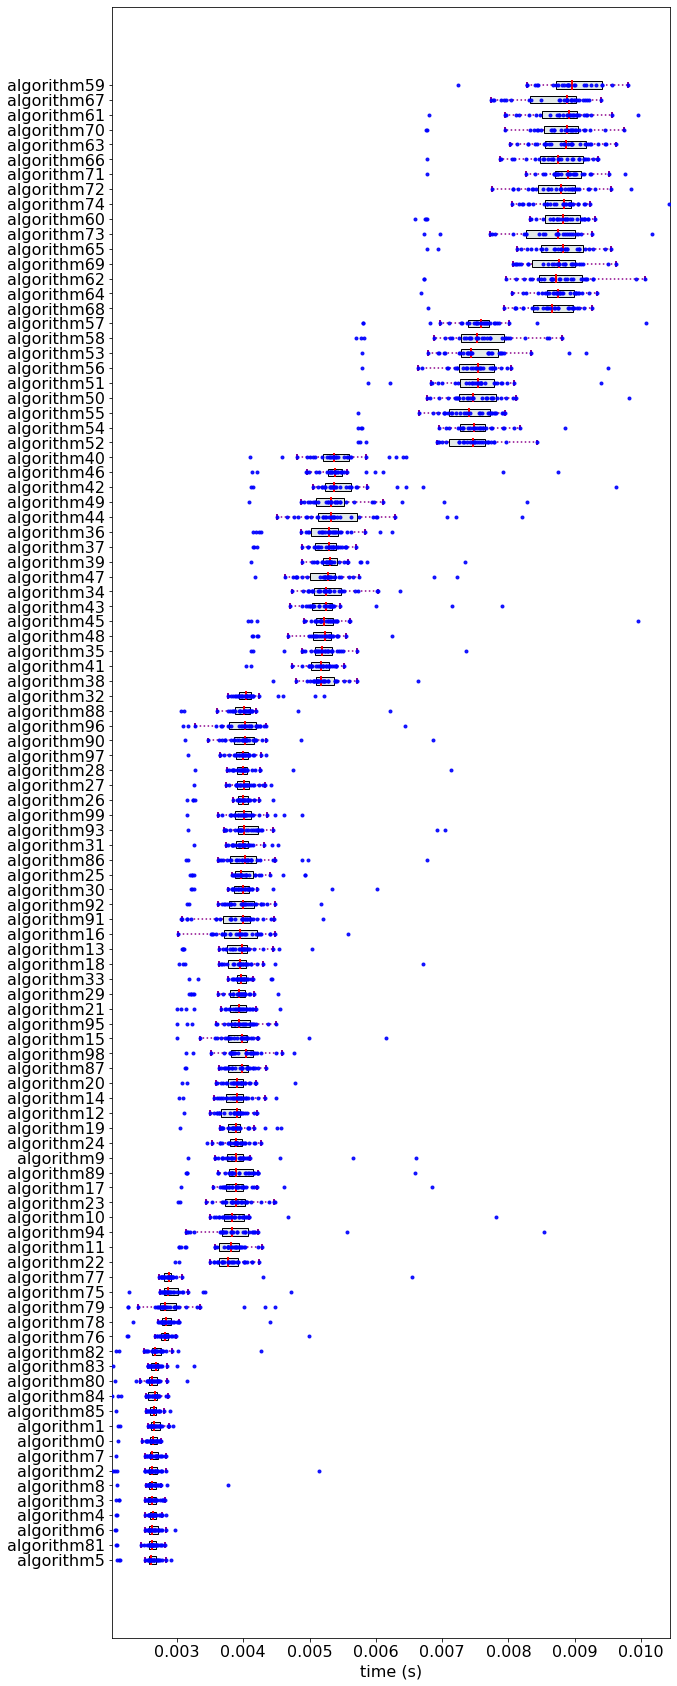

In [99]:
fig = rdl.visualize_box_plots('1000_150',scale=0.3)

In [114]:
rdl.obj_path

'codes/GLS/ranking-data/rdl_12T.pkl'

In [115]:
rdl.save()

In [135]:
rdl_ = RankingDataLinnea(dml,rm,'12T')

In [136]:
rdl_.data_kernels

In [137]:
rdl_.load()

In [138]:
rdl_.data_kernels

,node,class,flops,kernel
0,LAPACK.potrf_3.33e+08,0,333000000.0,LAPACK.potrf
1,LAPACK.potrf_333,1,333.0,LAPACK.potrf
2,LAPACK.syev_3.43e+03,0,3430.0,LAPACK.syev
3,gemm_1e+04,0,10000.0,gemm
4,gemm_2e+05,0,200000.0,gemm
...,...,...,...,...
79,syrk_1e+08,0,100000000.0,syrk
80,transpose_1,-1,1.0,transpose
81,trsm_1e+07,0,10000000.0,trsm
82,trsv_1e+04,0,10000.0,trsv


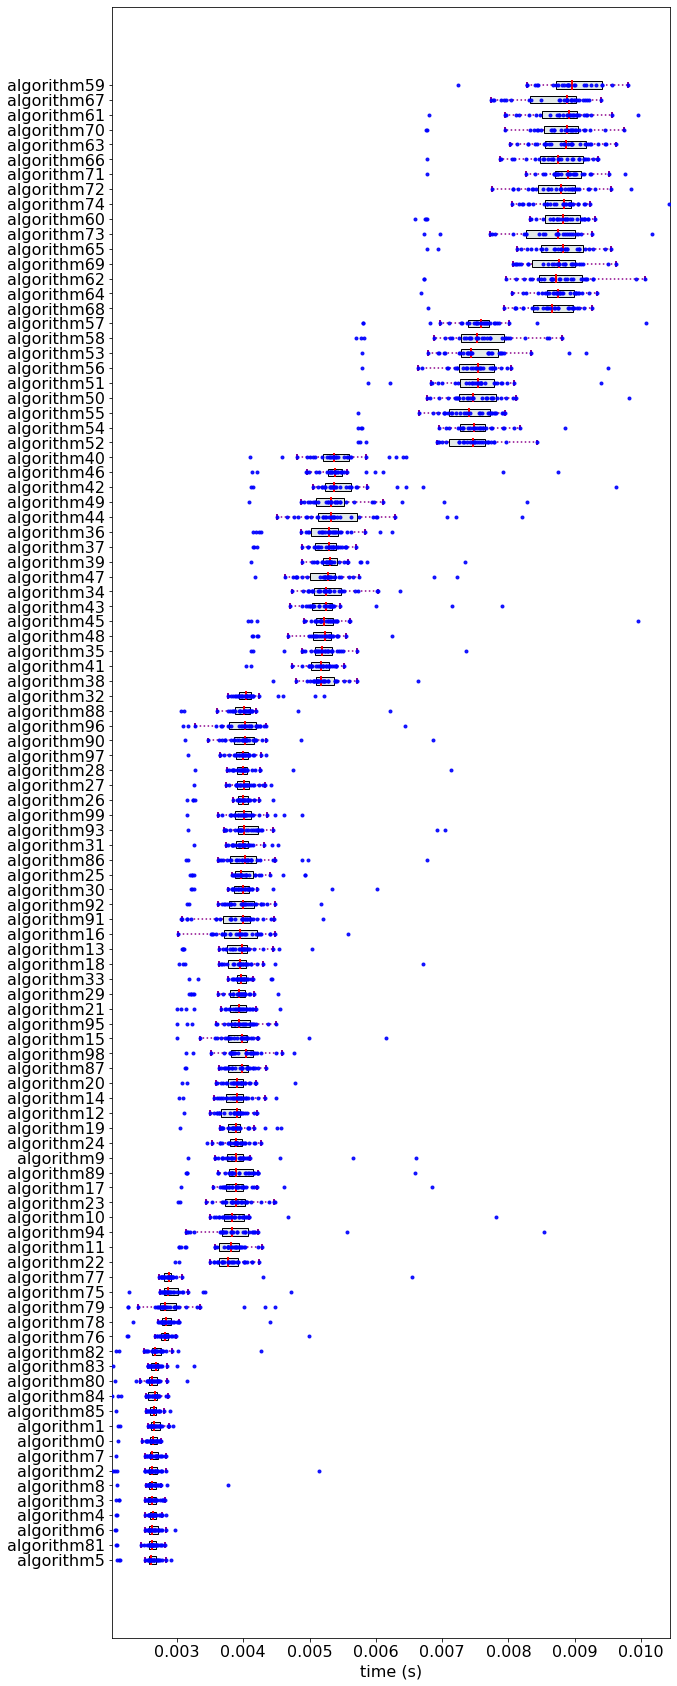

In [139]:
fig = rdl_.visualize_box_plots('1000_150',scale=0.3)